<a href="https://colab.research.google.com/github/sdhar2020/WebsiteCode/blob/main/3_Forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Menu
| | | | |

# Introduction

Forecasting the future is an art as old as humanity itself. The socery of modern math and algorithms has alwayss been an achilies heel and hence the interest to hack the code.

Improved forecast can improve predictability in business and prescient demand or the lack of it.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from IPython.display import clear_output

In [ ]:
train= pd.read_csv('https://raw.githubusercontent.com/sdhar-pycourse/py-datascience-biz/main/practise-datasets/train.csv')
train['datetime']= pd.to_datetime(train.datetime)
# train['flag']='train'
# train.set_index('datetime', inplace= True)
test= pd.read_csv('https://raw.githubusercontent.com/sdhar-pycourse/py-datascience-biz/main/practise-datasets/test.csv')
# test['flag']='test'
test['datetime']= pd.to_datetime(test.datetime)
# test.set_index('datetime', inplace= True)
df= pd.concat([train, test], axis=0, ignore_index=True)

In [ ]:
train.shape

(26496, 8)

In [ ]:
import holidays
# Select country
us_holidays = holidays.US()

def ExtractTimeFeatures(df, timefeature= 'datetime'):
  df['Year']= df.loc[:, timefeature].dt.year- df.loc[:, timefeature].dt.year.min()
  df['Month']= df.loc[:, timefeature].dt.month
  df['Week']= df.loc[:, timefeature].dt.week
  df['WeekDay']= df.loc[:, timefeature].dt.day_of_week
  df['Hour']= df.loc[:, timefeature].dt.hour
  df['NonWrkDay']= df.loc[:, timefeature].apply(lambda x: x in us_holidays) + df.loc[:, timefeature].dt.day_of_week.isin([5,6])
  return(df)

In [ ]:
train= ExtractTimeFeatures(train)
test= ExtractTimeFeatures(test)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  


# Train

In [ ]:
sum(train.datetime.value_counts()>1)

0

In [ ]:
train.columns

Index(['ID', 'datetime', 'temperature', 'var1', 'pressure', 'windspeed',
       'var2', 'electricity_consumption', 'Year', 'Month', 'Week', 'WeekDay',
       'Hour', 'NonWrkDay'],
      dtype='object')

# Test

In [ ]:
sum(test.datetime.value_counts()>1)

0

# Train & Test

In [ ]:
test.datetime.min().strftime('%Y-%m-%d HH:MM:SS')

'2013-07-24 HH:MM:SS'

In [ ]:
train.merge(test, how='inner', left_on='datetime', right_on='datetime')

,ID_x,datetime,temperature_x,var1_x,pressure_x,windspeed_x,var2_x,electricity_consumption,Year_x,Month_x,...,var1_y,pressure_y,windspeed_y,var2_y,Year_y,Month_y,Week_y,WeekDay_y,Hour_y,NonWrkDay_y


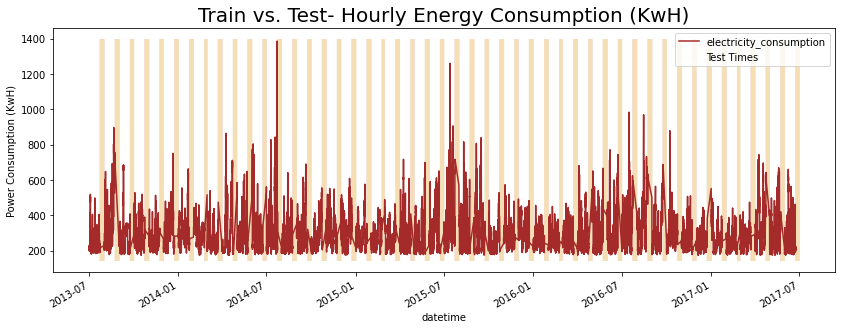

In [ ]:
# fig, ax = plt.subplots(figsize=(21,8))
my_dpi= 300
fig, ax = plt.subplots(figsize=(4200/my_dpi,1500/my_dpi)) 
train.plot(x= 'datetime', y= 'electricity_consumption', ax=ax, color= 'brown')
ax.vlines(x=test.datetime.tolist(), ymin= 140, ymax= 1400, colors='wheat', ls='--', lw=.05, label='Test Times')
plt.ylabel('Power Consumption (KwH)')
plt.legend()
plt.title('Train vs. Test- Hourly Energy Consumption (KwH)', fontsize=20)
plt.savefig('1.TrainTest.svg', bbox_inches='tight',fontsize = 20)
# pd.crosstab(df.datetime, df.flag, df.electricity_consumption, aggfunc='mean').plot(kind= 'line', y='train', ax=ax, color= 'gray')

In [ ]:
recs=[]
for index, row in test.iterrows():
  # clear_output(wait=True)
  df1= train.loc[train.datetime < row['datetime']]
  recs.append([int((df1.datetime.max()- df1.datetime.min()).days), df1.datetime.min(), df1.datetime.max(), row['datetime'], df1.shape[0]])

df2= pd.DataFrame.from_records(recs, columns=['TrainDateDays', 'TrainDateMin', 'TrainDateMax', 'TestDate', 'DataPointsTrain'])

In [ ]:
df3= df2.groupby('TrainDateDays').agg(TrainDateMin= ('TrainDateMin', np.min), TrainDateMax= ('TrainDateMax', np.max),\
                                 TestDateMin= ('TestDate', np.min), TestDateMax= ('TestDate', np.max), DataPointsTrain=('DataPointsTrain', np.mean))

In [ ]:
df3['TestDateDays']= (df3.TestDateMax- df3.TestDateMin).astype('timedelta64[h]')%24.0

In [ ]:
df3.reset_index(inplace= True)

In [ ]:
df3['TrainSegStartdt']= df3.TestDateMax.shift()

In [ ]:
df3.TrainSegStartdt.fillna(df3.TrainDateMin, inplace= True)

In [ ]:
df3[['TrainSegStartdt', 'TrainDateMax']].head()

,TrainSegStartdt,TrainDateMax
0,2013-07-01 00:00:00,2013-07-23 23:00:00
1,2013-07-31 23:00:00,2013-08-23 23:00:00
2,2013-08-31 23:00:00,2013-09-23 23:00:00
3,2013-09-30 23:00:00,2013-10-23 23:00:00
4,2013-10-31 23:00:00,2013-11-23 23:00:00


Text(0.5, 1.0, 'Train: Energy Consumption (KwH)- Rollling Means')

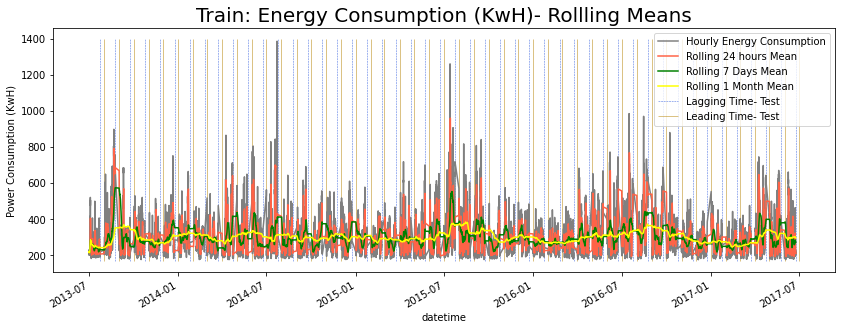

In [ ]:
# fig, ax = plt.subplots(figsize=(21,8))
my_dpi= 300
fig, ax = plt.subplots(figsize=(4200/my_dpi,1500/my_dpi)) 
train.plot(x= 'datetime', y= 'electricity_consumption', ax=ax, color= 'gray', label='Hourly Energy Consumption')
train.set_index('datetime').electricity_consumption.rolling(24, min_periods=1).mean().plot(ax=ax, color= 'tomato', label='Rolling 24 hours Mean')
train.set_index('datetime').electricity_consumption.rolling(24*7, min_periods=1).mean().plot(ax=ax, color= 'green', label='Rolling 7 Days Mean')
train.set_index('datetime').electricity_consumption.rolling(24*30, min_periods=1).mean().plot(ax=ax, color= 'yellow', label='Rolling 1 Month Mean')
ax.vlines(x=df3.TestDateMin.tolist(), ymin= 165, ymax= 1400, colors='royalblue', ls='--', lw=.5, label='Lagging Time- Test')
ax.vlines(x=df3.TestDateMax.tolist(), ymin= 165, ymax= 1400, colors='darkgoldenrod', ls='-', lw=.5, label='Leading Time- Test')
plt.ylabel('Power Consumption (KwH)')
plt.legend()
plt.title('Train: Energy Consumption (KwH)- Rollling Means', fontsize=20)
# plt.savefig('2.Rolling Means.svg', bbox_inches='tight',fontsize = 20)

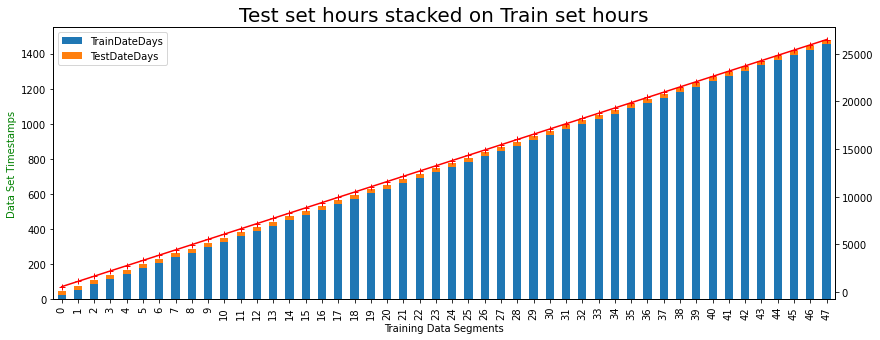

In [ ]:
my_dpi= 300
fig, ax1 = plt.subplots(figsize=(4200/my_dpi,1500/my_dpi)) 
ax2 = ax1.twinx()
df3[['TrainDateDays', 'TestDateDays']].plot(kind='bar', stacked=True, ax=ax1)
df3.DataPointsTrain.plot(kind='line', color= 'red', ax=ax2, secondary_y=True, marker='+')
ax1.set_xlabel('Training Data Segments')
ax1.set_ylabel('Data Set Timestamps', color='g')
ax2.set_ylabel('Total Training Data', color='b')
plt.title('Test set hours stacked on Train set hours', fontsize=20)
plt.savefig('2.TestTrainStacked.svg', bbox_inches='tight',fontsize = 20)

In [ ]:
train['cohort']=-999
df3[['TrainSegStartdt', 'TrainDateMax']].head()
for index, row in df3.iterrows():
  train.loc[train.datetime.between(row['TrainSegStartdt'], row['TrainDateMax']), 'cohort']= index

In [ ]:
train.shape

(26496, 15)

In [ ]:
t1= train.loc[train.electricity_consumption.between(train.electricity_consumption.quantile(.01),train.electricity_consumption.quantile(.99))]

In [ ]:
# t1= train.groupby('cohort', group_keys=False).apply(lambda x: x.sample(frac=0.3))

In [ ]:
LOOKUP_SEASON = {
    11: 'Winter',
    12: 'Winter',
    1: 'Winter',
    2: 'Spring',
    3: 'Spring',
    4: 'Spring',
    5: 'Summer',
    6: 'Summer',
    7: 'Summer',
    8: 'Fall',
    9: 'Fall',
    10: 'Fall'
}

In [ ]:
t1['Season']= t1.Month.map(LOOKUP_SEASON)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
from scipy.optimize import curve_fit

# Fit the function a * np.exp(b * t) + c to x and y
popt, pcov = curve_fit(lambda t, a, c: a/t+c, t1.windspeed.values, t1.electricity_consumption.values)

In [ ]:
popt

array([147.21430559, 265.3960801 ])

In [ ]:
# # Create the fitted curve
# # ax.legend()
# x=t1.windspeed.values
# x_fitted = np.linspace(np.min(x), np.max(x), 50)
# y_fitted = popt[0]*(1/x_fitted)+ popt[1]

# # Plot
# ax = plt.axes()
# ax.scatter(x, t1.electricity_consumption.values, label='Raw data')
# ax.plot(x_fitted, y_fitted, 'k', label='Fitted curve')
# ax.set_title(r'Using curve\_fit() to fit an exponential function')
# ax.set_ylabel('y-Values')
# ax.set_ylim(0, 700)
# ax.set_xlabel('x-Values')
# ax.legend()

In [ ]:
# from sklearn.preprocessing import PowerTransformer
# scaler = PowerTransformer(method = 'box-cox')
# # t1['ftwindspeed']= scaler.fit_transform(t1.windspeed.values.reshape(-1, 1))
# t1['ftwindspeed']= np.reciprocal(t1.windspeed.values.reshape(-1, 1))
# t1['ftwindspeed']= np.sqrt(t1.windspeed.values.reshape(-1, 1))
# t1['ftwindspeed']= np.power(t1.windspeed.values.reshape(-1, 1),2)

In [ ]:
# sns.scatterplot(data=t1, y= 'electricity_consumption', x="ftwindspeed", hue='Season')
# # set_title('4. Consumption vs. windspeed- ScatterPlot')

In [ ]:
t1['invwindspeed']= np.power(t1.windspeed,-1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
t1.columns

Index(['ID', 'datetime', 'temperature', 'var1', 'pressure', 'windspeed',
       'var2', 'electricity_consumption', 'Year', 'Month', 'Week', 'WeekDay',
       'Hour', 'NonWrkDay', 'cohort', 'Season', 'invwindspeed'],
      dtype='object')

In [ ]:
t1.electricity_consumption.mean()

294.60929570967244

In [ ]:
# sns.heatmap(pd.crosstab(t1.Hour, t1.WeekDay, t1.electricity_consumption, aggfunc='median'), cmap='coolwarm', center= t1.electricity_consumption.median())

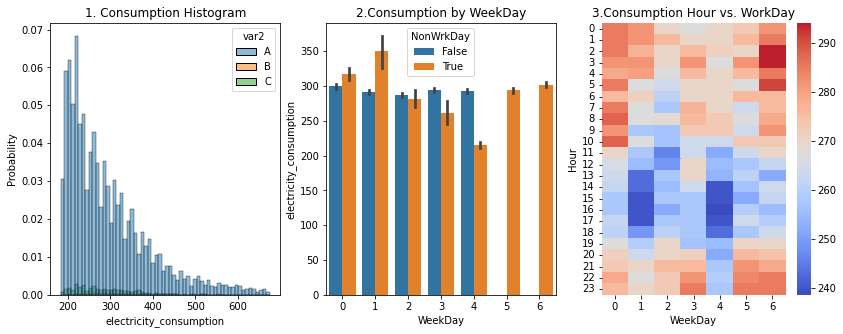

In [ ]:
my_dpi= 300
fig, ax = plt.subplots(1, 3,figsize=(4200/my_dpi,1500/my_dpi), sharey= False, )
sns.histplot(data=t1, ax=ax[0], x="electricity_consumption", hue="var2", stat='probability')
ax[0].set_title('1. Consumption Histogram')
sns.barplot(data=t1, y="electricity_consumption", x="WeekDay", hue= 'NonWrkDay', ax=ax[1])
ax[1].set_title('2.Consumption by WeekDay')
sns.heatmap(pd.crosstab(t1.Hour, t1.WeekDay, t1.electricity_consumption, aggfunc='median'), cmap='coolwarm', center= t1.electricity_consumption.median(), ax=ax[2])
ax[2].set_title('3.Consumption Hour vs. WorkDay')
plt.savefig('3.Hist.svg', bbox_inches='tight',fontsize = 20)

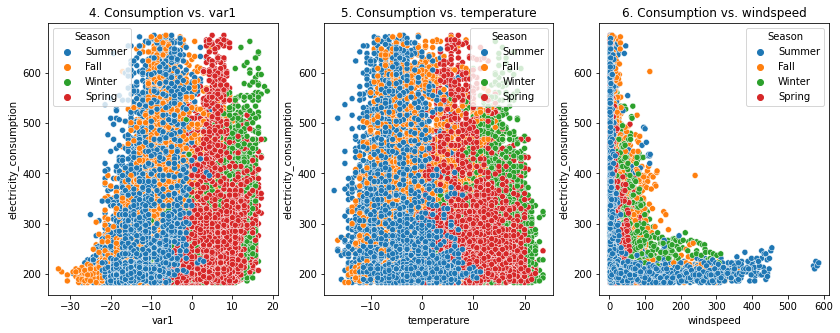

In [ ]:
my_dpi= 300
fig, ax = plt.subplots(1, 3,figsize=(4200/my_dpi,1500/my_dpi), sharey= False, )
sns.scatterplot(data=t1, ax=ax[0], x= 'var1', y="electricity_consumption", hue= 'Season')
ax[0].set_title('4. Consumption vs. var1')
sns.scatterplot(data=t1, ax=ax[1], x= 'temperature', y="electricity_consumption", hue= 'Season')
ax[1].set_title('5. Consumption vs. temperature')
sns.scatterplot(data=t1, ax=ax[2], y= 'electricity_consumption', x="windspeed",  hue= 'Season')
ax[2].set_title('6. Consumption vs. windspeed')
plt.savefig('4.Scater.svg', bbox_inches='tight',fontsize = 20)

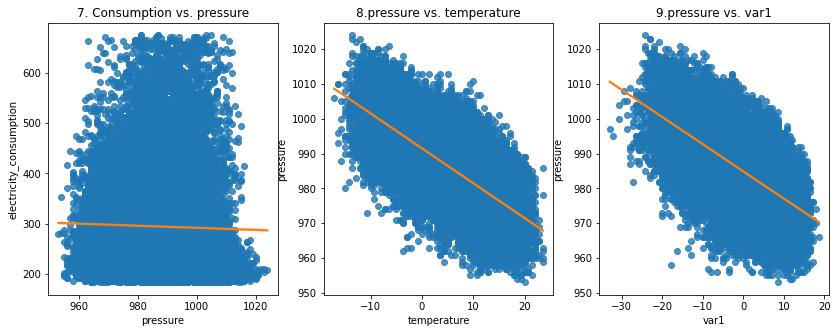

In [ ]:
my_dpi= 300
fig, ax = plt.subplots(1, 3,figsize=(4200/my_dpi,1500/my_dpi), sharey= False, )
sns.regplot(data=t1, ax=ax[0], y= 'electricity_consumption', x="pressure",  fit_reg=True, line_kws={"color": "C1"})
ax[0].set_title('7. Consumption vs. pressure')
sns.regplot(data=t1, ax=ax[1], y= 'pressure', x="temperature",  line_kws={"color": "C1"})
ax[1].set_title('8.pressure vs. temperature')
sns.regplot(data=t1, ax=ax[2], y= 'pressure', x="var1",  line_kws={"color": "C1"})
ax[2].set_title('9.pressure vs. var1')
plt.savefig('5.Regplot.svg', bbox_inches='tight',fontsize = 20)

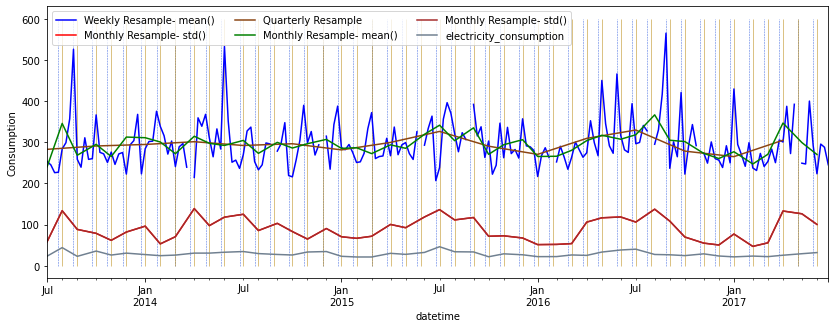

In [ ]:
my_dpi= 300
fig, ax = plt.subplots(figsize=(4200/my_dpi,1500/my_dpi), sharex= True, )
t1.resample('W',on='datetime').mean().loc[:,'electricity_consumption'].plot(color= 'blue', label='Weekly Resample- mean()', ax= ax)
t1.resample('M',on='datetime').std().loc[:,'electricity_consumption'].plot(color= 'red', label='Monthly Resample- std()', ax= ax)
t1.resample('Q',on='datetime').mean().loc[:,'electricity_consumption'].plot(color= 'saddlebrown', label='Quarterly Resample', ax= ax)
t1.resample('M',on='datetime').mean().loc[:,'electricity_consumption'].plot(color= 'green', label='Monthly Resample- mean()', ax= ax)
t1.resample('M',on='datetime').std().loc[:,'electricity_consumption'].plot(color= 'brown', label='Monthly Resample- std()', ax= ax)
t1.resample('H',on='datetime').mean().loc[:,'electricity_consumption'].diff().dropna().reset_index().resample('M',on='datetime').std().\
plot(color= 'slategray', label='Monthly std of daily diff std()', ax= ax)
plt.ylabel('Consumption')
ax.vlines(x=df3.TestDateMin.tolist(), ymin= 0, ymax= 600, colors='royalblue', ls='--', lw=.5)
ax.vlines(x=df3.TestDateMax.tolist(), ymin= 0, ymax= 600, colors='darkgoldenrod', ls='-', lw=.5)
plt.legend(loc='best', ncol=3)
plt.savefig('6.timeagg.svg', bbox_inches='tight',fontsize = 20)

In [ ]:
# my_dpi= 300
# fig, ax = plt.subplots(5, 1,figsize=(4500/my_dpi,3000/my_dpi), sharex= True, )
# t1.resample('W',on='datetime').mean().loc[:,'electricity_consumption'].plot(color= 'orangered', label='Monthly Resample', ax= ax[0])
# ax[0].set_title('1.Weekly Resampled Mean')
# t1.resample('M',on='datetime').std().loc[:,'electricity_consumption'].plot(color= 'brown', label='Monthly Resample', ax= ax[1])
# ax[1].set_title('2.Weekly Resampled Std()')
# t1.resample('M',on='datetime').mean().loc[:,'electricity_consumption'].plot(color= 'blue', label='Monthly Resample', ax= ax[2])
# ax[2].set_title('3.Monthly Resampled Mean')
# t1.resample('Q',on='datetime').mean().loc[:,'electricity_consumption'].plot(color= 'green', label='Monthly Resample', ax= ax[3])
# ax[3].set_title('4.Quarterly Resampled Mean')
# t1.resample('D', on='datetime').mean().loc[:,'electricity_consumption'].diff().plot(color= 'mediumvioletred', label='Daily Diff.', ax= ax[4])
# ax[4].set_title('5.Daily Consumption Diff')
# for i in range(5):
#   ax[i].vlines(x=df3.TestDateMin.tolist(), ymin= -400, ymax= 600, colors='royalblue', ls='--', lw=.5, label='Lagging Time- Test')
#   ax[i].vlines(x=df3.TestDateMax.tolist(), ymin= -400, ymax= 600, colors='darkgoldenrod', ls='-', lw=.5, label='Leading Time- Test')
# plt.savefig('6.timeseries.svg', bbox_inches='tight',fontsize = 20)